In [ ]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 14.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texliv

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0
    for i,j in edges:
      if b[i]!=b[j]:
        val = val - 1

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

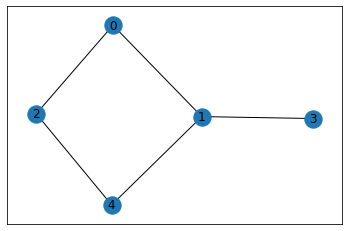

In [ ]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for n in range(0,n_qubits): # Each quantum bit is rotated by θ
      layer.apply(RX(2*theta),n)
    for i,j in edges: # Entering edge information: exp(i$\beta$ZZ)
      layer.apply(U_ZZ(2*beta),i,j)
    
    
    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for n in range(0,n_qubits): # Initialization
      prog.apply(H,qubits[n])
    for p in range(0,n_layers): # add QAOA layers
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*p], parameters[2*p+1]), qubits)
    
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)

    # BEGIN TODO

    # This step is calculate the cost:
    
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        
      val=0
      for i,j in edges: 
        if sample.state.bitstring[i] != sample.state.bitstring[j]:
          val=val-1
      val=val*sample.probability
      obs=obs+val
    # END TODO
    return obs
    
        

In [ ]:
import numpy as np
np.random.random(3)

array([0.30156145, 0.51178487, 0.23878662])

In [ ]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

-2.482895489208122 -2.9963090564502024 -3.2325397032021272 -3.6094024405582656 -3.671161576274894 -3.692547666699266 -3.692787901756653 -3.692805348416695 -3.6928053518651116 -3.6928053518696906 -2.570222896495279 -2.9814257062191696 -3.4693176264834387 -3.5737887102347523 -3.613133885319076 -3.6828296899001187 -4.240663460837477 -4.293018030077103 -4.375623848937831 -4.4780512530274725 -4.488006411339348 -4.4889223755213985 -4.4890379209501345 -4.489117266001543 -4.489133404146088 -4.489134495955768 -4.489134514733673 -4.4891345148281285 -2.7880675762590275 -2.8299688287488522 -2.90967599171171 -3.059981263390627 -4.050034582679628 -4.256011344426142 -4.27873500051226 -4.299244319029563 -4.300516009170441 -4.301212330336479 -4.301444101777533 -4.301508969034735 -4.301598956466586 -4.30161758172511 -4.301617761010412 -4.301617767802916 -4.3016177680252765 -2.559518385123119 -3.0649570850151515 -3.4053779647847677 -3.4850182216200554 -3.995505279867387 -4.18572346964795 -4.3079737574198

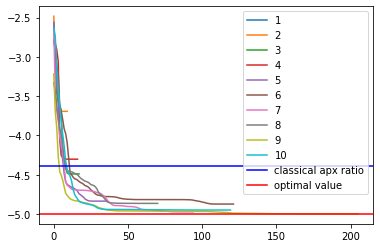

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(1,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

I think it needs at least 5 layers

### Question 6: smart initialization

-2.570683363460611 -2.5933433459441795 -3.6256201893770585 -3.6407413552160888 -3.664370313974096 -3.691905174022959 -3.692804337338096 -3.692805351537749 -3.692805351869507 -2.499226810438551 -2.5178267609877865 -2.913395406649874 -2.923333142689119 -3.013722168327436 -3.137446253885975 -3.282824160365599 -3.480152256315872 -3.6171646955846186 -3.6672566414547925 -3.680661219325943 -3.6912219206937076 -3.6928074136946143 -3.692856980116142 -3.6928729498394595 -3.6944027383673843 -3.6945487781530866 -3.695767402240703 -3.6977147799126144 -3.700847582272496 -3.703936236995092 -3.704145889390667 -3.7043691571544413 -3.7047193564189937 -3.7049944734457347 -3.7050556493758457 -3.705068212670433 -3.7050690853663166 -3.7050691199354238 -3.705069146397253 -2.7960748427097974 -2.9657216290726356 -3.0645751449018066 -3.2378818694998373 -3.3299662754553814 -3.845769747863733 -3.8794622237446768 -3.9207216555304303 -3.9949643600867124 -4.125270074841238 -4.200248230651819 -4.205552752958017 -4.20

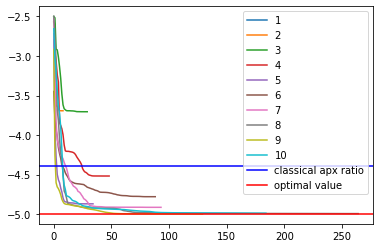

In [ ]:
T = 1.

for nlayers in range(1,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = [0 for i in range(0,2*num_params)]
    for s in range(0,num_params):
      T=num_params
      parameters_init[2*s]=1-s/T
      parameters_init[2*s+1]=s/T

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

The speed of convergence has to be more stable than with the previous randomly selected values